# Pre-analysis script

* load hdf5
* plot average XRD pattern
* check image center
* make mask
* check angular integration

### import stuff

In [1]:
import numpy as np
import h5py 
from pathlib import Path
import matplotlib.pyplot as plt
import time
import sys
try:
    from escape.parse import swissfel
    from jungfrau_utils import apply_gain_pede, apply_geometry
except ImportError:
    print('activate bernina conda: source /sf/bernina/bin/anaconda_env')
    sys.exit(-1)

In [2]:
sys.path.insert(0, '../src/')
from data_tools import *
from fit_tools import *
from integrators import *
from utilities import *

ModuleNotFoundError: No module named 'skbeam'

In [1]:
### load swissfel gain and pedestal

In [ ]:
gain_path = '/sf/bernina/config/jungfrau/gainMaps/JF07T32V01/gains.h5'
pede_path = '/sf/bernina/data/p17743/res/JF_pedestals/pedestal_20190115_1551.JF07T32V01.res.h5'
with h5py.File(gain_path, 'r') as f:
    gains = f['gains'][:]
with h5py.File(pede_path, 'r') as f:
    pede = f['gains'][:]
    noise = f['gainsRMS'][:]
    mask = f['pixel_mask'][:]

### parse swissfel data and accumulate average img

In [3]:
run = 0
path = '/sf/bernina/data/p17743/res/scan_info/run%04d_test01.json' % run
data = swissfel.parseScanEco_v01(path, createEscArrays=True, memlimit_mD_MB=50) # False outputs h5 handles, True outputs escape arrays
jf7 = data['JF07T32V01']

#fh5 = h5py.File(path, 'r')
#run_key   = [ k for k in fh5.keys() if k.startswith('run_') ][0]
#tags      = fh5['/%s/detector_2d_assembled_1'%run_key].keys()[1:]

# -- image generator
num_im = len(jf7.data.shape[jf7.eventDim])
print('There are %d events to be processed' % num_im)
img_gen   = ( jf7.data[im].compute() for im in range(num_im) )
mean_int = np.zeros(num_im)

# -- average image
im_avg = img_gen.next()
i=0
for im_next in img_gen:
    t1 = time.time() 
    d = apply_gain_pede(im_next, G=gains, P=pede, pixel_mask=mask)
    mean_int[i] = np.average(d.flatten())
    im_avg += apply_geometry(d, 'JF07T32V01')
    i  += 1
    print 'R.%d | S.%d/%.d | %.1f Hz'%(run,i,num_im,1.0/(time.time() - t1))
im_avg /= num_im


R.689947 | S.1/100 | 36.5 Hz
R.689947 | S.2/100 | 79.5 Hz
R.689947 | S.3/100 | 77.5 Hz
R.689947 | S.4/100 | 75.8 Hz
R.689947 | S.5/100 | 75.4 Hz
R.689947 | S.6/100 | 81.5 Hz
R.689947 | S.7/100 | 79.2 Hz
R.689947 | S.8/100 | 81.1 Hz
R.689947 | S.9/100 | 78.7 Hz
R.689947 | S.10/100 | 80.5 Hz
R.689947 | S.11/100 | 78.2 Hz
R.689947 | S.12/100 | 57.3 Hz
R.689947 | S.13/100 | 68.8 Hz
R.689947 | S.14/100 | 79.6 Hz
R.689947 | S.15/100 | 77.4 Hz
R.689947 | S.16/100 | 79.3 Hz
R.689947 | S.17/100 | 80.3 Hz
R.689947 | S.18/100 | 79.2 Hz
R.689947 | S.19/100 | 80.2 Hz
R.689947 | S.20/100 | 80.8 Hz
R.689947 | S.21/100 | 69.8 Hz
R.689947 | S.22/100 | 78.8 Hz
R.689947 | S.23/100 | 50.3 Hz
R.689947 | S.24/100 | 50.7 Hz
R.689947 | S.25/100 | 58.0 Hz
R.689947 | S.26/100 | 56.0 Hz
R.689947 | S.27/100 | 55.6 Hz
R.689947 | S.28/100 | 56.8 Hz
R.689947 | S.29/100 | 52.3 Hz
R.689947 | S.30/100 | 45.0 Hz
R.689947 | S.31/100 | 59.8 Hz
R.689947 | S.32/100 | 80.4 Hz
R.689947 | S.33/100 | 79.4 Hz
R.689947 | S.34/100

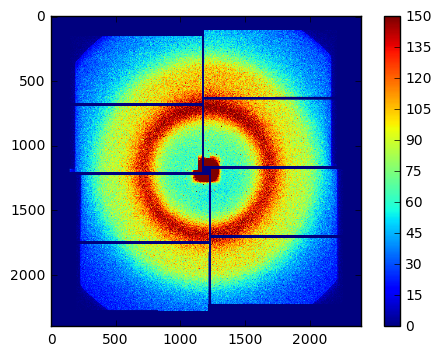

In [4]:
plt.imshow(im_avg, origin='lower', vmin=0)
plt.colorbar()
plt.show()

### Check image center (cx,cy)

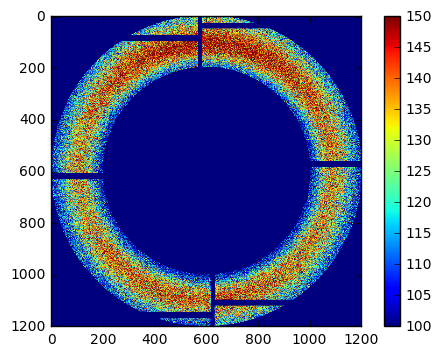

In [5]:
cx,cy = 1200,1200 
rd = 600
rmask = ring_mask(im,(cx,cy),inner_radius=400,width=200,spacing=0,num_rings=1)

plt.figure()
plt.imshow(im[cx-rd:cx+rd,cy-rd:cy+rd]*rmask[cx-rd:cx+rd,cy-rd:cy+rd],vmin=1e2,vmax = 1.5e2)
plt.colorbar()
plt.show()

### Make mask 

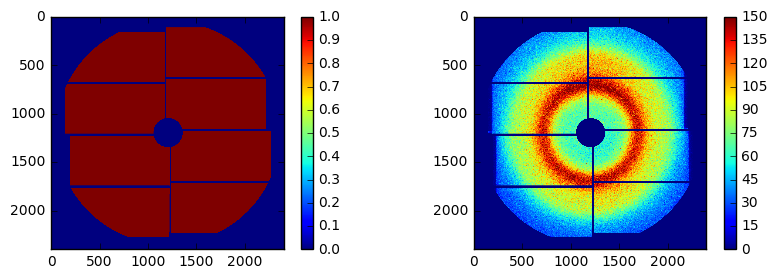

In [10]:
# ring mask
mask = ring_mask(im,(cx,cy),inner_radius=150,width=1000,spacing=0,num_rings=1)
mask[im==0]=0

plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.imshow(mask,vmin=0,vmax = 1)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mask*im,vmin=0,vmax = 1.5e2)
plt.colorbar()
plt.show()

### Angular integration

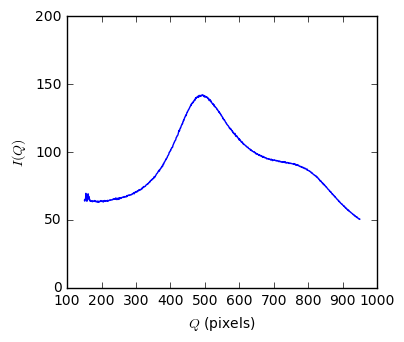

In [21]:
# angular integration 
n_bins = 1000           # number of bins
min_x,max_x = 150,950     #n_bins
mask_thr = 1            # threshold limit for integrator 

# angular intergation
qbin,Iq = angular_average(im, (cx,cy),mask,threshold=mask_thr, nx=n_bins,  min_x=min_x, max_x=max_x)
plt.figure(figsize=[4,3.5])
plt.plot(qbin,Iq,'b-')
plt.ylim(0,200)
plt.ylabel(r'$I(Q)$')
plt.xlabel(r'$Q$ (pixels)')
#plt.xlabel(r'$Q$ $\rm(\AA^{-1})$')
plt.show()